# IMU Gesture Recognition - EEIA 2025

This notebook implements gesture recognition using IMU sensor data (accelerometer and gyroscope) as part of a project during EEIA 2025.
## Objective
Create a machine learning model that can:
- Recognize predefined gestures from IMU sensor data
- Be robust to noise and imperfect capture conditions
- Be suitable for embedded applications

## Dataset
- 3,500 observations from a 6-axis IMU sensor
- Features: Ax, Ay, Az (acceleration), Gx, Gy, Gz (angular velocity)
- Target: Movement types (categorical)

## 1. Data Loading

Let's load our training and test datasets:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Xtrain = pd.read_csv(r"C:\Users\HP\EEIA2025\IMU_Gesture_Recognition\data\X_train.csv") # data\X_train.csv
ytrain = pd.read_csv(r"C:\Users\HP\EEIA2025\IMU_Gesture_Recognition\data\y_train.csv")

# Training data concatenation
train_data = pd.concat([Xtrain, ytrain], axis=1)
# Display first rows of training data
train_data.head()

,Ax,Ay,Az,Gx,Gy,Gz,Target
0,-0.112570,-0.236957,-0.709937,-46.174066,-49.126185,195.597917,Horizontal
1,1.137907,-1.196851,0.132819,127.578112,-43.363560,-55.962775,Horizontal
2,2.232311,0.230752,1.308039,17.710502,6.279586,-159.935481,Horizontal
3,0.108860,1.724140,-1.676828,-0.947682,-45.063266,10.579303,Oblique2
4,-0.626974,0.420363,0.923636,-18.032825,4.388338,0.191381,Horizontal


## Exploration Data Analysis (EDA)

The Exploration Data Analysis (EDA) is a fundamental step in every machine learning project. It helps us to better understand the structure, the quality and the particularities of the dataset. Thanks to the EDA, we arrived to :

- Identify the presence of lacking and aberrant values;
- Visualize the variables' distribution and their relationship with the target;
- Detect prospective clasees imbalance;
- Highlight interresting collerations or patterns.




The Exploratory Data Analysis (EDA) is a fundamental step in every machine learning project. It helps us to better understand the structure, quality and characteristics of the dataset. Through EDA, we can:

- Identify missing values and outliers
- Visualize variable distributions and their relationships with the target
- Detect potential class imbalances
- Highlight interesting correlations and patterns

In [3]:
# Dataset dimensions
print(f"Number of observations: {train_data.shape[0]}")
print(f"Number of variables: {train_data.shape[1]}")

Number of observations: 3500
Number of variables: 7


In [4]:

# Descriptives statistics
print("Descriptives statistics :")
display(train_data.describe())


Descriptives statistics :


,Ax,Ay,Az,Gx,Gy,Gz
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,0.050377,0.411583,0.113097,2.767744,2.690189,0.323272
std,0.962928,0.834899,0.886334,51.736337,68.348399,61.069234
min,-3.457646,-2.712044,-3.193500,-250.802113,-251.824318,-250.799593
25%,-0.613890,-0.139508,-0.497276,-22.352937,-23.815284,-29.180209
50%,0.071694,0.404710,0.127173,2.910593,2.706540,-0.146731
75%,0.715479,0.966740,0.713866,26.858836,30.082101,30.381256
max,3.077745,3.252791,3.668151,250.614038,251.301515,251.645543


In [ ]:

# Missing values checking
print("Missing values by column :")
train_data.isnull().sum()


Lacking values by column :


Ax        0
Ay        0
Az        0
Gx        0
Gy        0
Gz        0
Target    0
dtype: int64

'Target' classes partitioning :


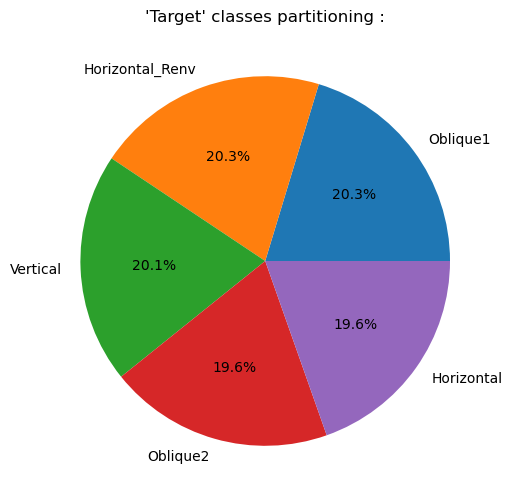

In [6]:

# Target classes partitioning
print("'Target' classes partitioning :")
train_data['Target'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6))
plt.title("'Target' classes partitioning :")
plt.ylabel('')
plt.show()


<Figure size 1200x800 with 0 Axes>

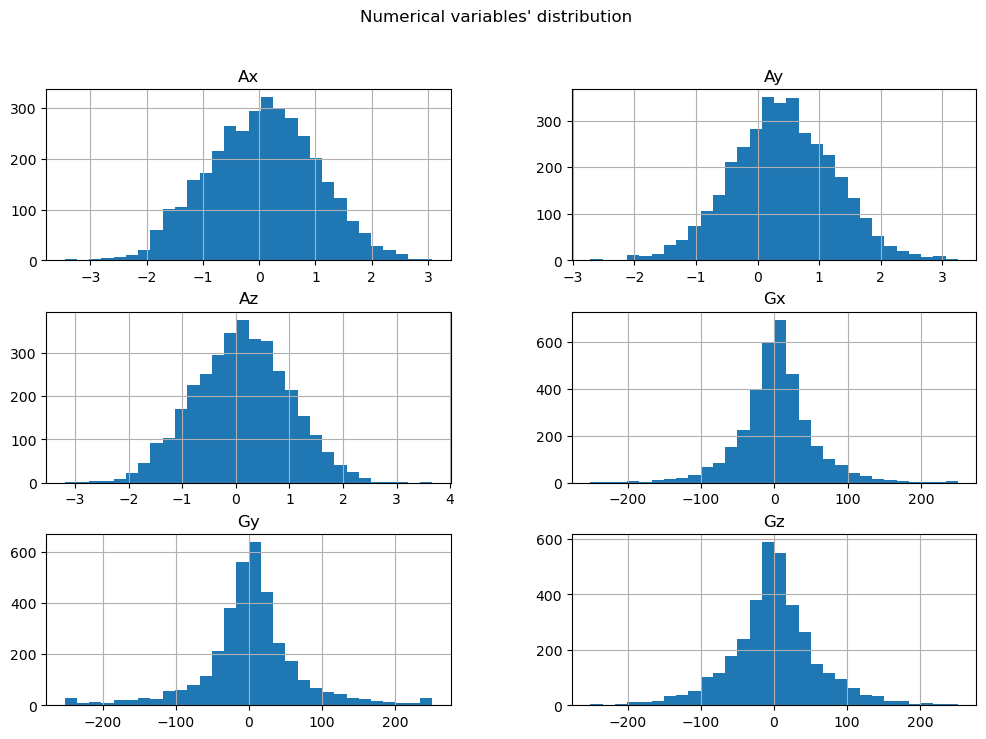

In [7]:
# Numerical variables distribution's visualization
plt.figure(figsize=(12, 8))
train_data.drop('Target', axis=1).hist(bins=30, figsize=(12, 8))
plt.suptitle("Numerical variables' distribution")
plt.show()

<Figure size 1600x1200 with 0 Axes>

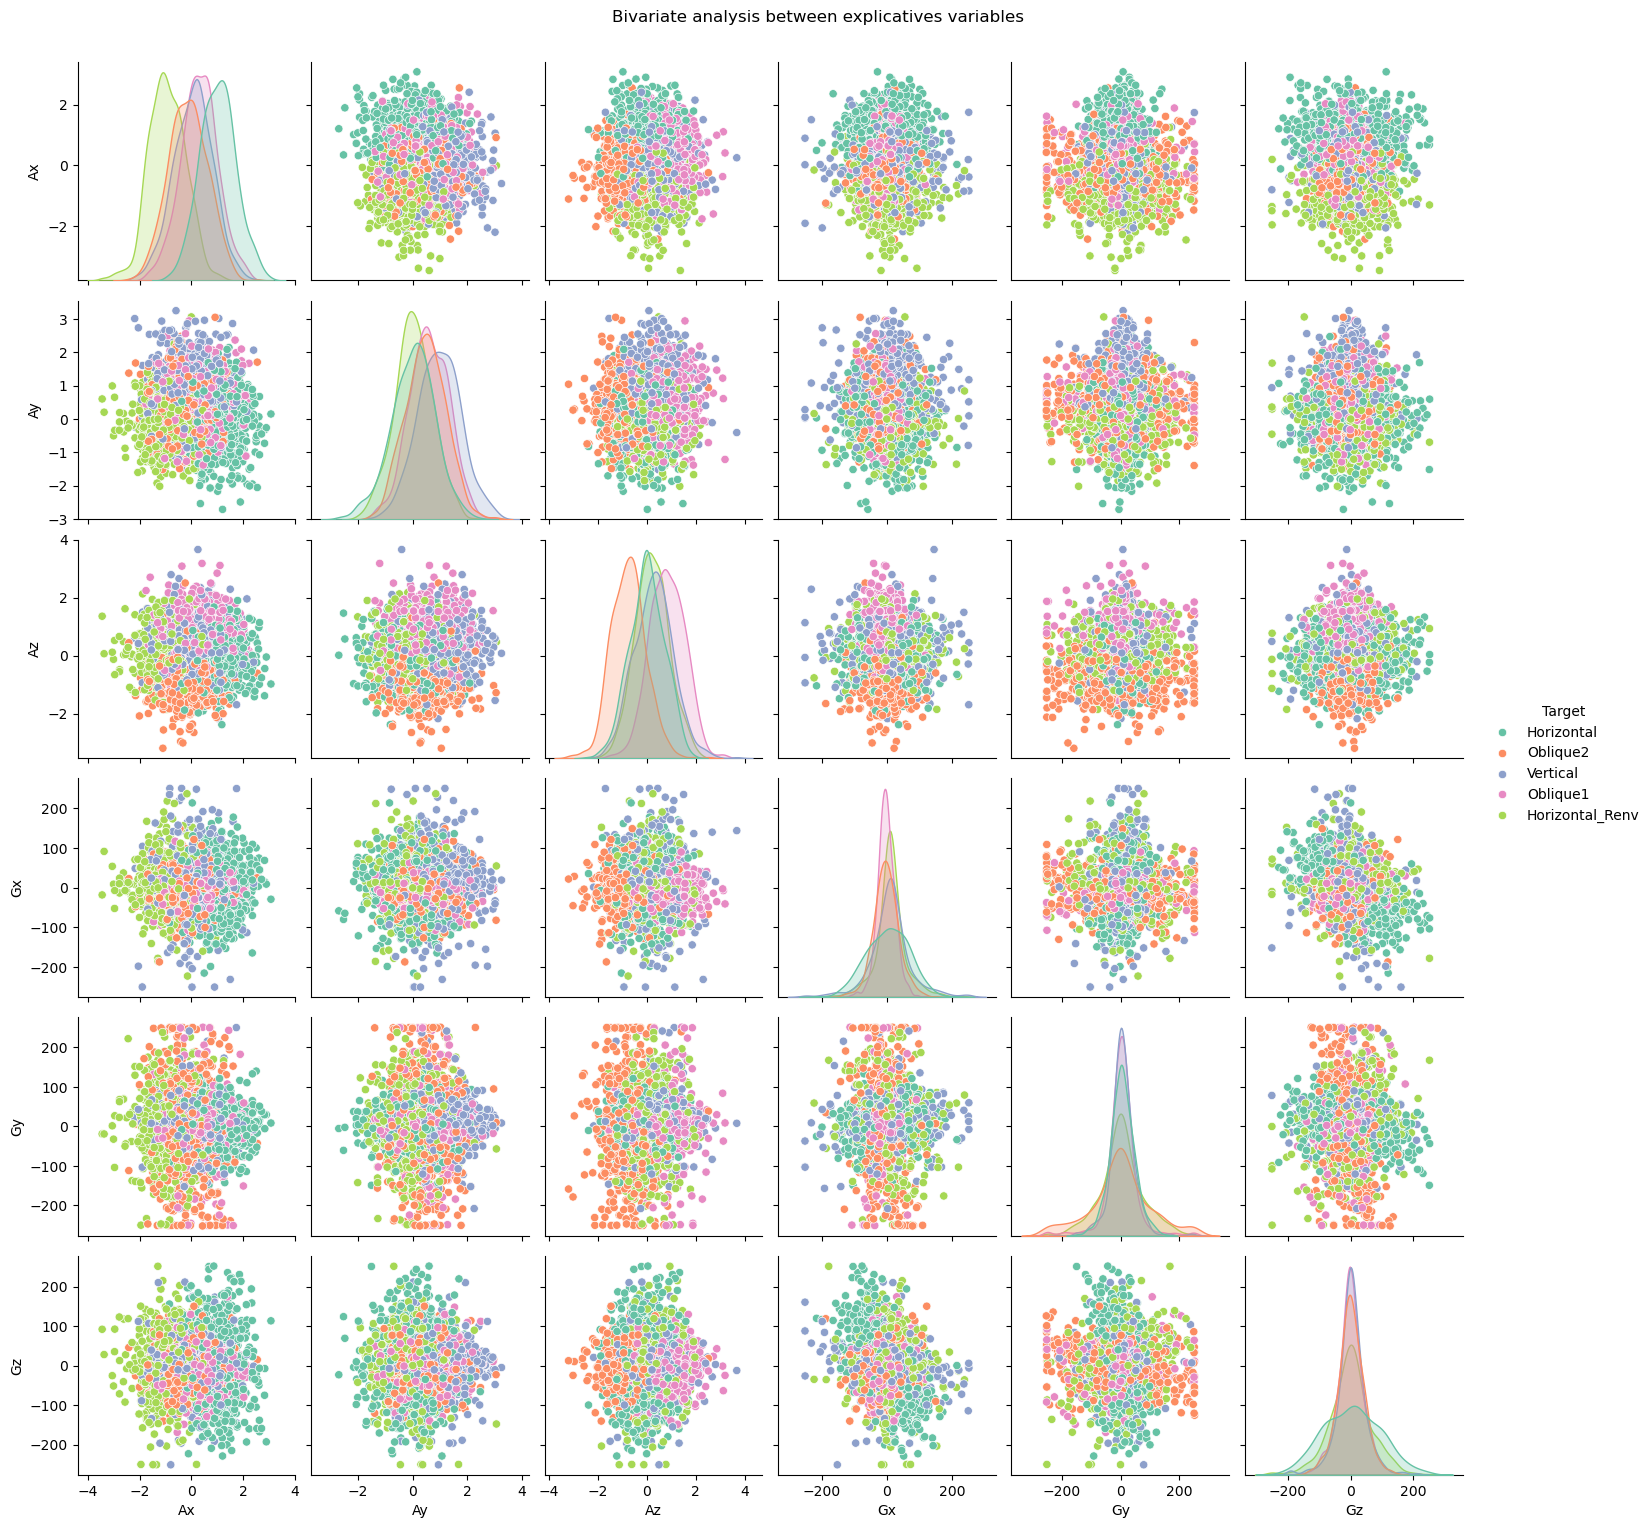

In [ ]:
# Bivariate analysis between features
plt.figure(figsize=(16, 12))
sns.pairplot(train_data, diag_kind='kde', hue='Target', palette='Set2')
plt.suptitle("Bivariate analysis between features", y=1.02)
plt.show()

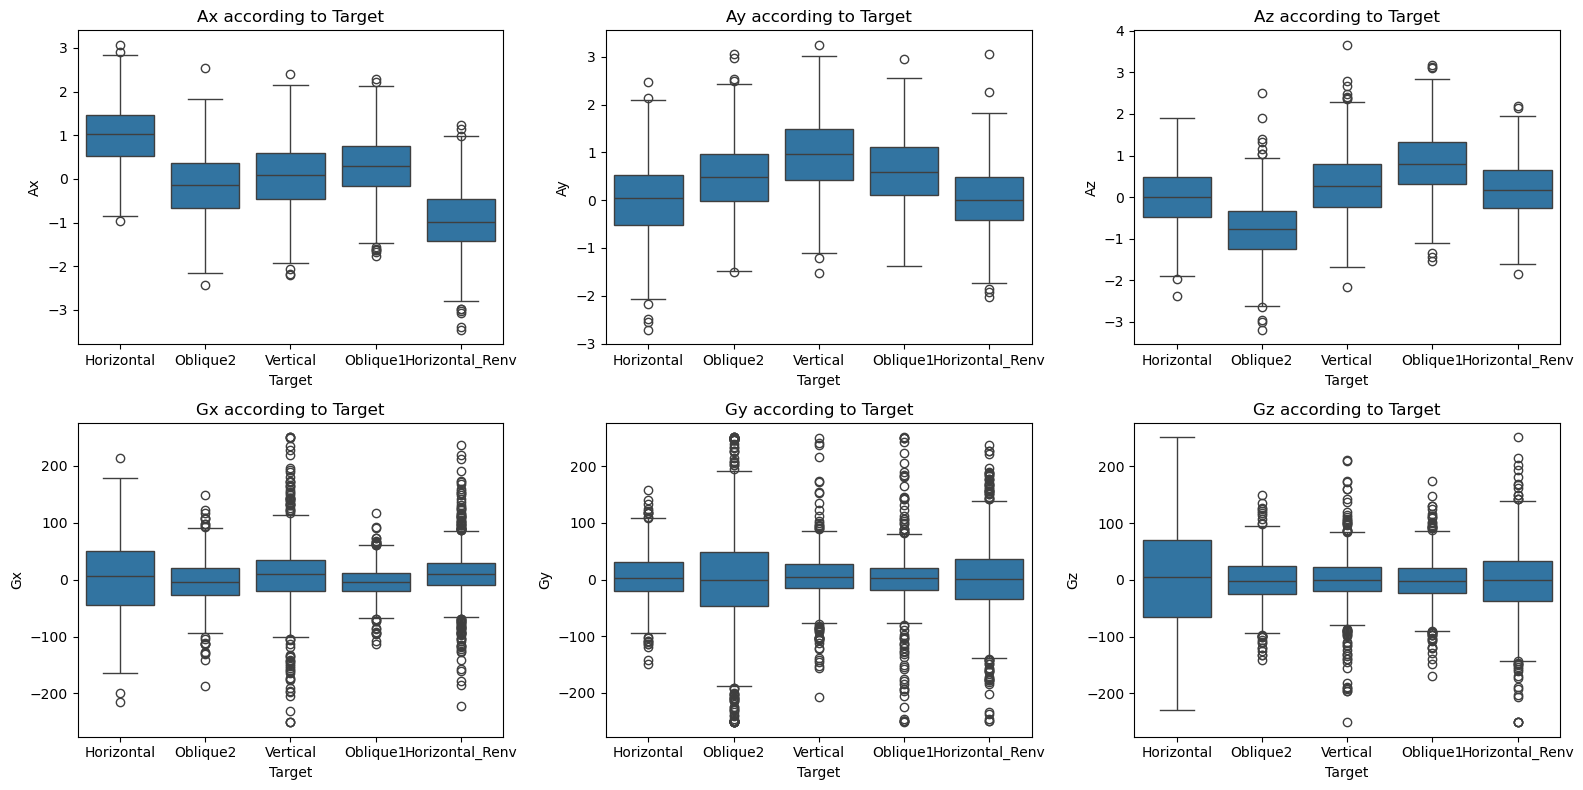

In [9]:
# Bivariate analysis : Visualization of the relationships between numerical variables and the target
plt.figure(figsize=(16, 8))
for i, col in enumerate(train_data.columns[:-1], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Target', y=col, data=train_data)
    plt.title(f"{col} according to Target")
plt.tight_layout()
plt.show()

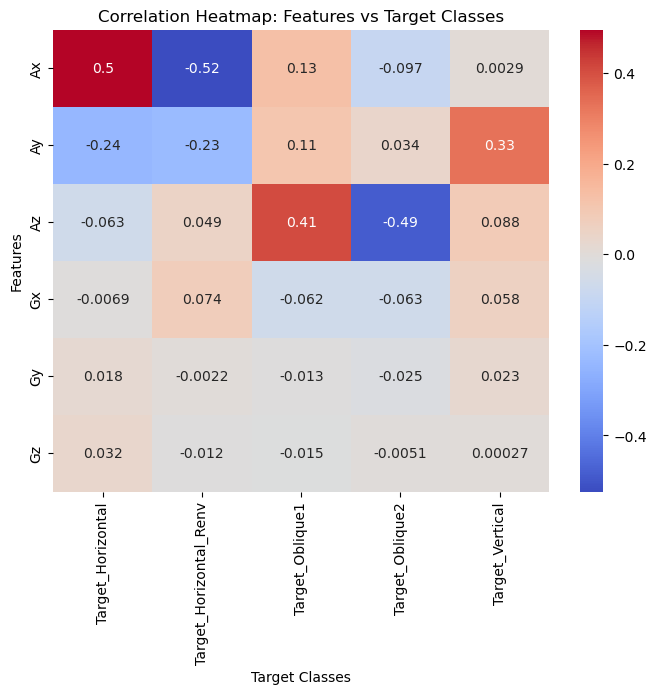

In [10]:
# Calculation of the correlation matrix between the features and the target classes
df_corr = Xtrain.copy()
df_corr['Target'] = ytrain['Target']
df_corr_encoded = pd.get_dummies(df_corr, columns=['Target'])

# Correlation between each feature and each target class
corr_matrix = df_corr_encoded.corr().loc[Xtrain.columns, [col for col in df_corr_encoded.columns if col.startswith('Target_')]]

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Features vs Target Classes')
plt.xlabel('Target Classes')
plt.ylabel('Features')
plt.show()

### Conclusion

This thorough understanding guides directly the following steps :

- **Preprocessing** : The EDA reveals the necessary operations to clean and prepare the data (imputation, encoding, normalization, etc.).
- **Feature Engineering** : It inspires the creation or the selection of novel pertinent variables that could improve the perfomance of the models.

To sum up, a rigorous exploratory analysis allows to take informed decisions in order to optimize the machine learning pipeline and maximize the chances to obtain reliable and robust results.

## Preprocessing 

### What is the preprocessing ?

The **preprocessing** is an essential step in machine learning that consists to preparing and transforming the raw data before utilizing them to train a model. This phase allows to improve the quality of the data, therefore, the perfomances of the algorithms.

The main operations of preprocessing include :
- **Data cleaning** : missing values management, duplicate removal, incoherences correction.
- **Variables encoding** : transformation of categorical variables into numerical variables (eg : Label Encoding, One-Hot Encoding).
- **Normalization et standardization** : mise à l'échelle des variables numériques pour faciliter l'apprentissage des modèles.
- **Variables selection** : choix des variables pertinentes pour le modèle.
- **Data spliting** : séparation du jeu de données en ensembles d'entraînement et de test.

Un bon preprocessing est crucial pour obtenir des modèles robustes et fiables.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Target class encoding
le = LabelEncoder()
train_data['Target_encoded'] = le.fit_transform(train_data['Target'])

# Splitting features and target
X = train_data.drop(['Target', 'Target_encoded'], axis=1)
y = train_data['Target_encoded']

print(y.head())

# Dataset split 75/25
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

print("Dimensions of training and validation sets:")
X_train.shape, X_val.shape, y_train.shape, y_val.shape

0    0
1    0
2    0
3    3
4    0
Name: Target_encoded, dtype: int32
Dimensions of training and validation sets:


((2625, 6), (875, 6), (2625,), (875,))

## Training

The choice of model depends on the nature of the data, the problem to solve, and the desired performance.

For classification problems, there are various models available. These models range from linear methods like logistic regression to nonlinear approaches such as random forests, k-nearest neighbors (KNN), or neural networks.

In Python, the `scikit-learn` (sklearn) library offers a wide range of classification algorithms that are easy to use and integrate into machine learning workflows. Other popular packages include `XGBoost`, `LightGBM`, and `TensorFlow`/`Keras` for more advanced or specialized models, particularly in deep learning.

It is common to test several algorithms to select the one that offers the best results on the studied dataset.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# K-NN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluation 

**Accuracy** is the evaluation metric. It measures the proportion of observations correctly classified by the model across all classes.

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{TP + TN}{TP + TN + FP + FN}
$$

But in a multi-class framework (with 5 classes as here), we can write:

$$
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\hat{y}_i = y_i)
$$

where:

* $N$ is the total number of observations,
* $\hat{y}_i$ is the predicted class for observation $i$,
* $y_i$ is the true class,
* $\mathbf{1}(\cdot)$ is the indicator function that equals 1 if the equality is true and 0 otherwise.

In [13]:
from sklearn.metrics import accuracy_score

# Evaluation on training and validation sets
y_pred_logreg_train = logreg.predict(X_train)
acc_logreg_train = accuracy_score(y_train, y_pred_logreg_train)
print(f"Logistic Regression Accuracy (train): {acc_logreg_train:.4f}")

y_pred_logreg = logreg.predict(X_val)
acc_logreg = accuracy_score(y_val, y_pred_logreg)
print(f"Logistic Regression Accuracy (val): {acc_logreg:.4f}")

y_pred_knn_train = knn.predict(X_train)
acc_knn_train = accuracy_score(y_train, y_pred_knn_train)
print(f"K-NN Accuracy (train): {acc_knn_train:.4f}")

y_pred_knn = knn.predict(X_val)
acc_knn = accuracy_score(y_val, y_pred_knn)
print(f"K-NN Accuracy (val): {acc_knn:.4f}")

y_pred_rf_train = rf.predict(X_train)
acc_rf_train = accuracy_score(y_train, y_pred_rf_train)
print(f"Random Forest Accuracy (train): {acc_rf_train:.4f}")

y_pred_rf = rf.predict(X_val)
acc_rf = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest Accuracy (val): {acc_rf:.4f}")

Logistic Regression Accuracy (train): 0.5947
Logistic Regression Accuracy (val): 0.5749
K-NN Accuracy (train): 0.5722
K-NN Accuracy (val): 0.3897
Random Forest Accuracy (train): 1.0000
Random Forest Accuracy (val): 0.6343


## Results

In [14]:
# Loading test results data
X_test = pd.read_csv(r"C:\Users\HP\EEIA2025\IMU_Gesture_Recognition\data\X_test.csv")

# Selecting the best model
best_model = rf

# Predictions on final test set
y_pred_final = best_model.predict(X_test)

# Inverse transform encoding to get original labels
y_pred_labels = le.inverse_transform(y_pred_final)

# Creating result DataFrame
results = pd.DataFrame({'Target': y_pred_labels})

# Saving to CSV file
results.to_csv('results.csv', index=False)

# Displaying result DataFrame
results.head()

,Target
0,Oblique1
1,Horizontal_Renv
2,Horizontal
3,Horizontal
4,Oblique1
